In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

reload(sys)  
sys.setdefaultencoding('utf8')

In [74]:
train = pd.read_csv("data/train_1.csv")
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [75]:
train.shape

(145063, 551)

In [76]:
train.Page.head()

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
Name: Page, dtype: object

In [77]:
#split page column with '_' and take the last three values
metadata = pd.DataFrame((row.split('_')[-3:] for row in train.Page), columns=['host', 'access', 'agent'])
#get the lang part from 'zh.wikipedia.org'
metadata['lang'] = metadata.host.str.split('.').str.get(0)
metadata.head()

,host,access,agent,lang
0,zh.wikipedia.org,all-access,spider,zh
1,zh.wikipedia.org,all-access,spider,zh
2,zh.wikipedia.org,all-access,spider,zh
3,zh.wikipedia.org,all-access,spider,zh
4,zh.wikipedia.org,all-access,spider,zh


In [78]:
trainDF = pd.concat([train,pageDetails], axis=1)

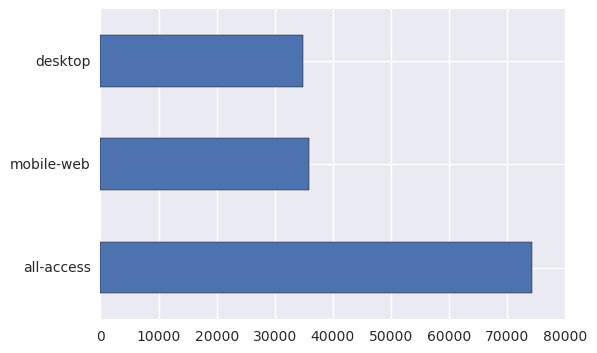

In [79]:
trainDF.access.value_counts().plot(kind="barh")

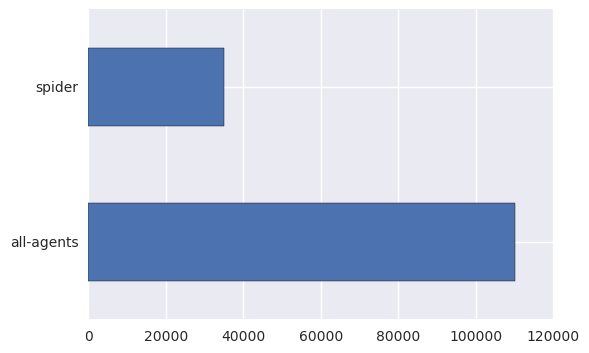

In [80]:
trainDF.agent.value_counts().plot(kind="barh")

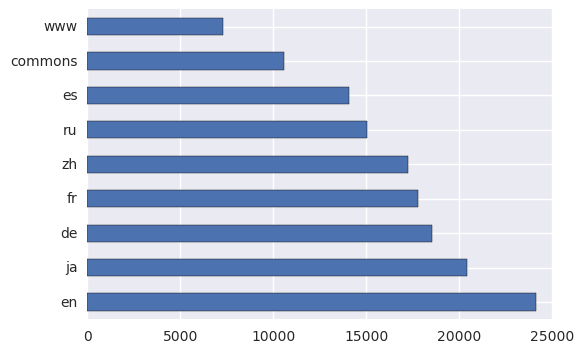

In [81]:
trainDF.lang.value_counts().plot(kind="barh")

In [82]:
trainDF[trainDF.lang=='www'].Page.head(10)
#generally lang==www does not contain any language information they are mediawiki articles

19611    "Keep_me_logged_in"_extended_to_one_year_www.m...
19612    2017_wikitext_editor_www.mediawiki.org_all-acc...
19613    2017_wikitext_editor/Feedback_www.mediawiki.or...
19614          API_www.mediawiki.org_all-access_all-agents
19615    API:Account_creation_www.mediawiki.org_all-acc...
19616    API:Allimages_www.mediawiki.org_all-access_all...
19617    API:Allpages_www.mediawiki.org_all-access_all-...
19618    API:Backlinks_www.mediawiki.org_all-access_all...
19619    API:Categoryinfo_www.mediawiki.org_all-access_...
19620    API:Client_Code_www.mediawiki.org_all-access_a...
Name: Page, dtype: object

In [83]:
trainDF[trainDF.lang=='commons'].Page.head(10)
#generally lang==commons does not contain any language information they are wikimedia articlese the warnings, itertools, pandas, numpy, matplotlib and statsmodels libraries. The warnings and itertools libraries come incle the warnings, itertools, pandas, numpy, matplotlib and statsmodels libraries. The warnings and itertools libraries come incl

13332      Accueil_commons.wikimedia.org_all-access_spider
13333    Atlas_of_Asia_commons.wikimedia.org_all-access...
13334    Atlas_of_Europe_commons.wikimedia.org_all-acce...
13335    Atlas_of_World_War_II_commons.wikimedia.org_al...
13336    Atlas_of_colonialism_commons.wikimedia.org_all...
13337    Atlas_of_the_United_Kingdom_commons.wikimedia....
13338    Atlas_of_the_United_States_commons.wikimedia.o...
13339       Bikini_commons.wikimedia.org_all-access_spider
13340    Campaign:OFBA2016_commons.wikimedia.org_all-ac...
13341    Catalogue_of_Wilhelm_von_Gloeden's_pictures_co...
Name: Page, dtype: object

## Analysis of Time Series according to languages

In [85]:
trainDF.lang.unique()

array(['zh', 'fr', 'en', 'commons', 'ru', 'www', 'de', 'ja', 'es'], dtype=object)

In [90]:
langDict = {}
langDict['zh'] = trainDF[trainDF.lang=='zh']
langDict['fr'] = trainDF[trainDF.lang=='fr']
langDict['en'] = trainDF[trainDF.lang=='en']
langDict['commons'] = trainDF[trainDF.lang=='commons']
langDict['ru'] = trainDF[trainDF.lang=='ru']
langDict['www'] = trainDF[trainDF.lang=='www']
langDict['de'] = trainDF[trainDF.lang=='de']
langDict['ja'] = trainDF[trainDF.lang=='ja']
langDict['es'] = trainDF[trainDF.lang=='es']

In [96]:
langDict['en'].iloc[:1]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,host,access,agent
8357,!vote_en.wikipedia.org_desktop_all-agents,3.0,4.0,7.0,4.0,4.0,2.0,3.0,7.0,2.0,...,3.0,1.0,1.0,3.0,3.0,1.0,0.0,en.wikipedia.org,desktop,all-agents
